## **Time Series Forecasting**

----

Time series exist in a variety of fields from meteorology to finance, econometrics,and marketing. By recording data and analyzing it, we can study time series to ana-lyze industrial processes or track business metrics, such as sales or engagement.Also, with large amounts of data available, data scientists can apply their expertiseto techniques for time series forecasting. 

In short, a time series is simply a set of data points ordered in time.Furthermore, the data is often equally spaced in time, meaning that equal intervalsseparate each data point. In simpler terms, the data can be recorded at every hour orevery minute, or it could be averaged over every month or year. Some typical exam-ples of time series include the closing value of a particular stock, a household’s electricity consumption, or the temperature outside.

## **Importing Libraries and the data**

----

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from IPython.display import Image
import os
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,  plot_pacf
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
pd.options.mode.chained_assignment = None

In [2]:
print("Current Working Directory:", os.getcwd()) 

Current Working Directory: C:\Users\raimu\Desktop\New folder (2)


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/marcopeix/AppliedTimeSeriesAnalysisWithPython/main/data/jj.csv')

df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [4]:
df['year'] = pd.DatetimeIndex(df['date']).year

df

,date,data,year
0,1960-01-01,0.71,1960
1,1960-04-01,0.63,1960
2,1960-07-02,0.85,1960
3,1960-10-01,0.44,1960
4,1961-01-01,0.61,1961
...,...,...,...
79,1979-10-01,9.99,1979
80,1980-01-01,16.20,1980
81,1980-04-01,14.67,1980
82,1980-07-02,16.02,1980


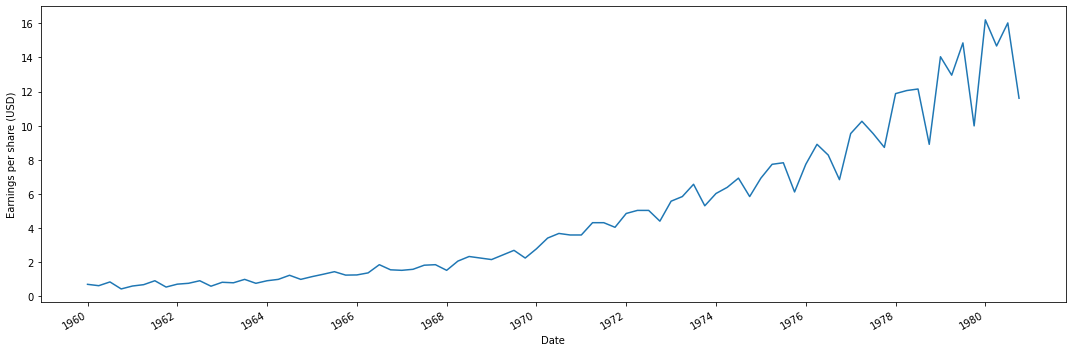

In [5]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(df.date, df.data)

ax.set_xlabel('Date')

ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

As you can see, figure above clearly represents a time series. The data is indexed bytime, as marked on the horizontal axis. Also, the data is equally spaced in time, since itwas recorded at the end of every quarter of each year. We can see that the data has atrend, since the values are increasing over time. We also see the earnings going up and down over the course of each year, and the pattern repeats every year.

### **Components of a time series**

We can further our understanding of time series by looking at their three compo-nents: a trend, a seasonal component, and residuals. In fact, all time series can bedecomposed into these three elements.Visualizing the components of a time series is known as decomposition. Decomposition is defined as a statistical task that separates a time series into its different components. Using the seasonal_decompose method we have:

Period = 4 for quarterly earnings

In [6]:
advanced_decomposition = STL(df.data, period=4).fit()

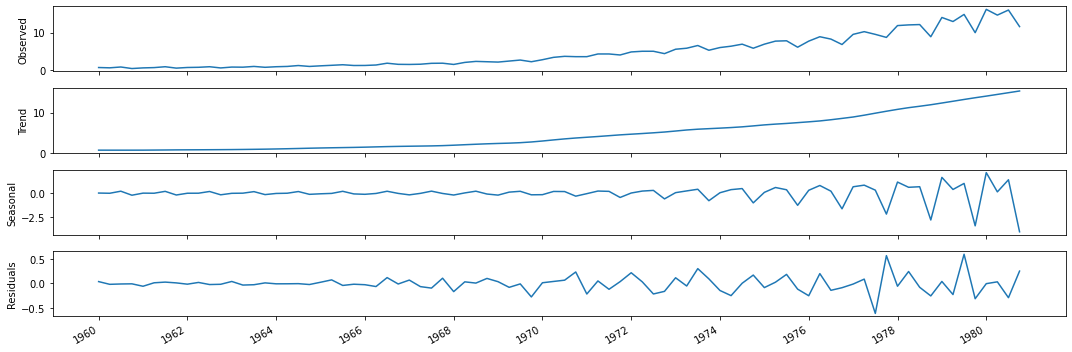

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(15, 5))

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')


plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

From top to bottom we have:
    
   - First, the top graph, labeled as Observed, simply shows the time series as it was recorded;
   - Then we have the trend component defined as defined as the slow-moving changes in a time series. In this case we can see an increase overtime. Trend it is also know as level;
   - The seasonal component captures the seasonal variation, which is a cycle that occurs over a fixed period of time. In this case we see an increase in fluctuation
   - The residuals, which is what cannot beexplained by either the trend or the seasonal components. We can think of the residuals as adding the Trend and Seasonal graphs together and comparing the value at each point in time to the Observed graph. The Residuals graph shows what value must be added to Trend and Seasonal in order to adjust the result and get the same value as in Observed. Residuals usually correspond to random errors, also termed white noise represent information that we cannot model.

So in hindsight, forecasting is predicting the future using historical data and knowledge of futureevents that might affect our forecasts. This definition is full of promises and, as data scientists, we are often very eager to start forecasting by using our scientific knowledge to showcase an incredible model with a near-perfect forecast accuracy. However, there are important steps that must be covered before reaching the point of forecasting.

The first concept to keep in mind is that time series have an order, and we cannot change that order when modeling. In time series forecasting, we express future values as a function of past values. Therefore, we must keep the data in order, so as to not violate this relationship.

So how do we make predictions??

**Lets import some stock data**

In [8]:
data = yf.download("GOOG", start="2010-01-01", end = "2022-12-31")

[*********************100%***********************]  1 of 1 completed


In [9]:
data = data["Close"]

In [10]:
data.head()

Date
2010-01-04 00:00:00-05:00    15.610239
2010-01-05 00:00:00-05:00    15.541497
2010-01-06 00:00:00-05:00    15.149715
2010-01-07 00:00:00-05:00    14.797037
2010-01-08 00:00:00-05:00    14.994298
Name: Close, dtype: float64

For this exercise I am going to model a random walk. A random walk is a process in which there is an equal chance of going up or down by arandom number. This is usually observed in financial and economic data, like the daily closing price of GOOGL. Random walks often expose long periods where a positive or negative trend can be observed. They are also often accompanied by sudden changes in direction as seen bellow.

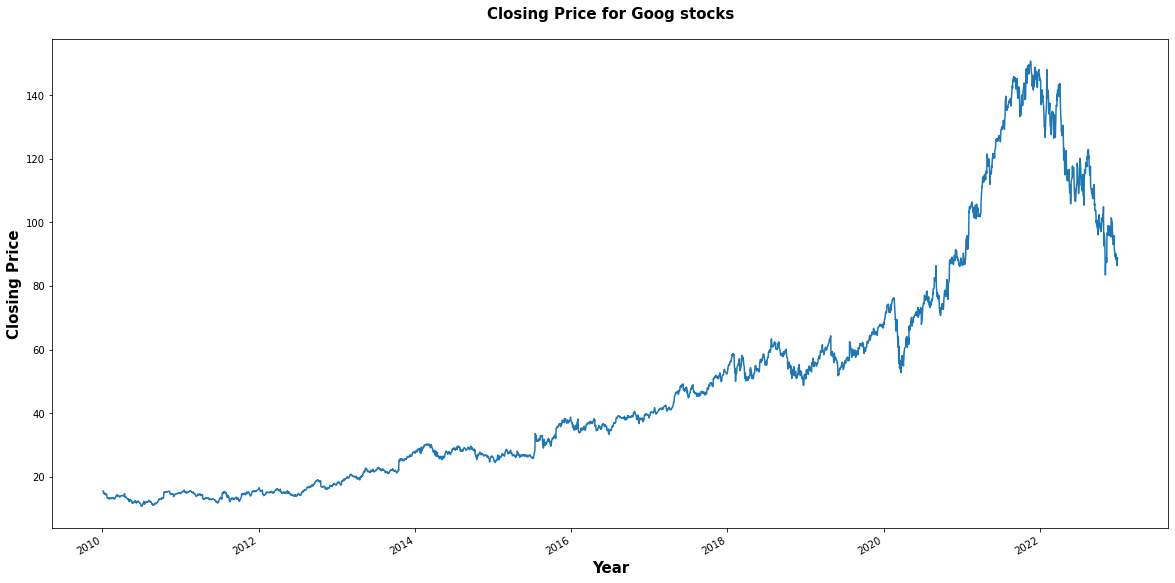

In [11]:
plt.figure(figsize = (20, 10))

data.plot()

plt.title("Closing Price for Goog stocks", loc ="center", pad = 20, fontsize = 15, fontweight = "bold")
plt.xlabel("Year", fontsize=15, weight = 'bold')
plt.ylabel("Closing Price", fontsize=15, weight = 'bold')

plt.show()

In a random walk process, we say that the present value yt is a function of the valueat the previous timestep yt –1, a constant C, and a random number εt, also termed white noise. Here, εt is the realization of the standard normal distribution, which has a variance of 1 and a mean of 0. Therefore, we can mathematically express a random walk with the following equation, where y t is the value at the present time t, C is a constant, yt –1 is the value at the previous timestep t–1, and εt is a random number:

yt = C + yt–1 + εt 

Note that if the constant C is nonzero, we designate this process as a random walk with drift.

So how do we model a random walk? For simplicity sake let's assume that C = 0

In [12]:
np.random.seed(42) ## This seed is to ensure that each time we run the code the same data points are always produced

steps = np.random.standard_normal(1000) ## We generate 1000 data points with normal distribution

steps[0]=0 ## We start here at moment 0

random_walk = np.cumsum(steps) ## We then assume continuous steps. Each step will consist of the sum with the previous noise so y1 = εt1, y2 = εt1 + εt2 ...

Plotting the data

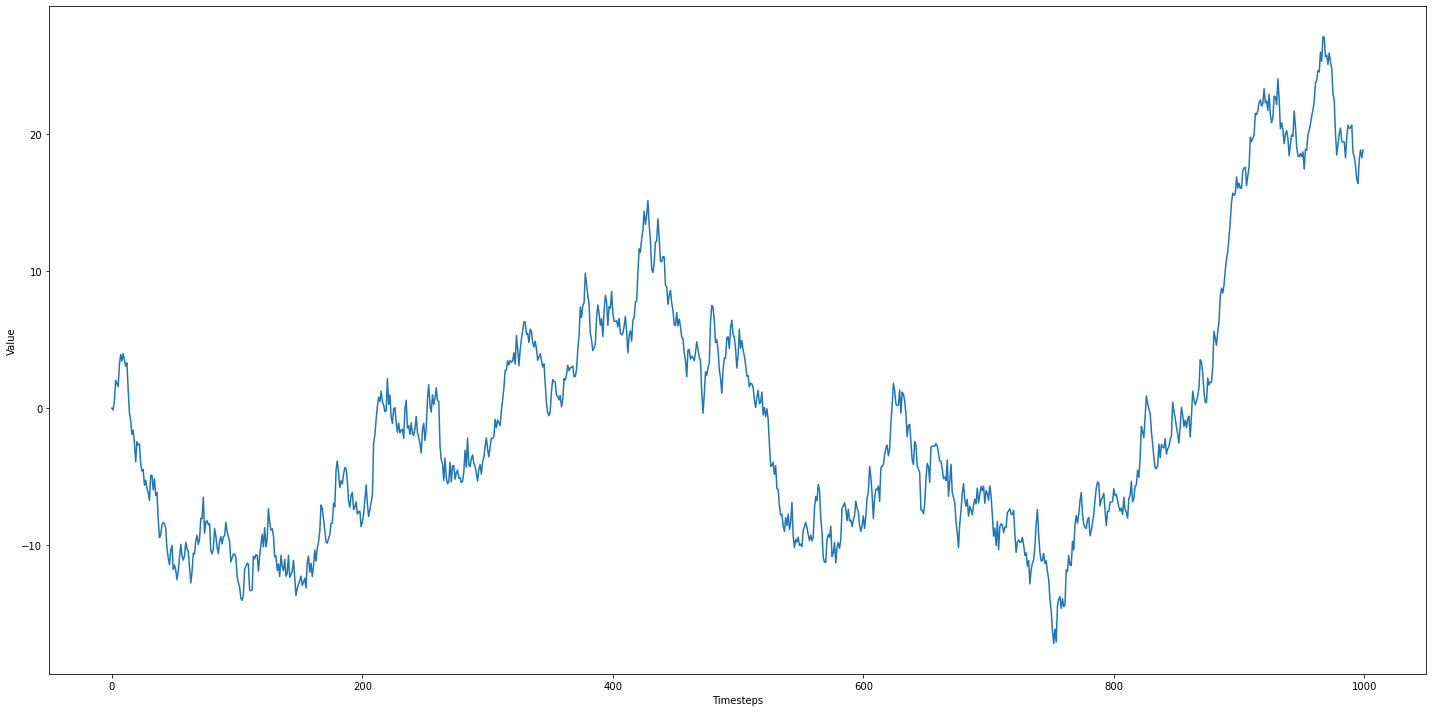

In [13]:
fig, ax = plt.subplots(figsize = (20, 10))

ax.plot(random_walk)

ax.set_xlabel('Timesteps')

ax.set_ylabel('Value')

plt.tight_layout()

By initializing our random walk process at 0 and setting the constant C to 0, we determine that the value at time t is simply the sum of white noise from t = 1 to time t. Thus, our simulated random walk will respect the equation 3.6, where yt is the value of the random walk process at time t, and εt is a random number at time t. We know this is a random walk because we simulated it. However, when dealingwith real-life data, we need to find a way to identify whether our time series is a random walk or not. Let’s see how we can achieve this:

**Random walk: A random walk is a series whose first difference is stationary and uncorrelated. This means that the process moves completely at random.**

## **Stationarity**

A stationary time series is one whose statistical properties do not change over time. In other words, it has a constant mean, variance, and autocorrelation, and these properties are independent of time. For now, since we are still in the early stages of time series forecasting, we’ll focus on stationary time series, which means that we will need to find ways to transform our time series to make them stationary. A transformation is simply a mathematical manipulation of the data that stabilizes its mean and variance, thus making it stationary.The simplest transformation one can apply is differencing. This transformation helps stabilize the mean, which in turn removes or reduces the trend and seasonality effects. Differencing involves calculating the series of changes from one timestep to another.

**Differencing: y't = yt - yt-1**

While differencing is used to obtain a constant mean through time, we must also make sure we have a constant variance in order for our process to be stationary. Logarithms are used to help stabilize the variance. Transformation in time series forecasting. A transformation is a mathematical operation applied to a time series in order to make it stationary. Differencing is a transformation that calculates the change from one timestep to  another. This transformation is useful for stabilizing the mean. Applying a log function to the series can stabilize its variance. Keep in mind that when we model a time series that has been transformed, we must untransform it to return the results of the model to the original units of measurement. The formal term for undoing a transformation is inverse transform. Therefore, if you apply a log transformation to your data, make sure you raise your forecast values to the power of 10 in order to bring the values back to their original magnitude. That way, your predictions will make sense in their original context.

Once a transformation is applied to a time series, we need to test for stationarity to determine if we need to apply another transformation to make the time series stationary, or if we need to transform it at all. A common test is the augmented Dickey-Fuller (ADF) test. The ADF test verifies the following null hypothesis: there is a unit root present in a time series. The alternative hypothesis is that there is no unit root, and therefore the time series is stationary. The result of this test is the ADF statistic, which is a negative number. The more negative it is, the stronger the rejection of the null hypothesis. In its implementation in Python, the p-value is also returned. If its value is less than 0.05, we can also reject the null hypothesis and say the series is stationary.

## **Auto Correlation**

Once a process is stationary, plotting the autocorrelation function (ACF) is a great way to understand what type of process you are analyzing. In this case, we will use it to determine if we are studying a random walk or not. The ACF reveals how the correlation between any two values changes as the lag increases. Here, the lag is simply the number of timesteps separating two values. So putting it all together:

In [14]:
ADF_result = adfuller(random_walk)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.965952487691875
p-value: 0.7654789696692581


A p-value greater than 0.05, we cannot reject the null hypothesis stating that our time series is not stationary. We can further support our conclusion by plotting the ACF function:

<Figure size 1440x720 with 0 Axes>

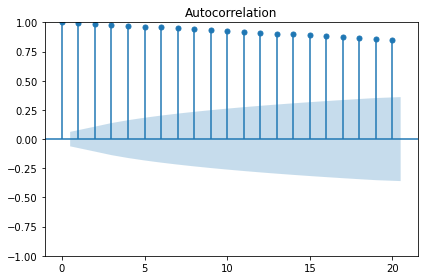

In [15]:
plt.figure(figsize = (20, 10))

plot_acf(random_walk, lags=20);

plt.tight_layout()

You’ll notice how the autocorrelation coefficients slowly decrease as the lag increases, which is a clear indicator that our random walk is not a stationary process. Note that the shaded area represents a confidence interval. If a point is within the shaded area, then it is not significantly different from 0. Otherwise, the autocorrelation coefficient is significant. Because our random walk is not stationary, we need to apply a transformation to make it stationary in order to retrieve useful information from the ACF plot. Since our sequence mostly displays changes in the trend without seasonal patterns, we will apply a first-order differencing. Remember that we’ll lose the first data point every time we difference.

In [16]:
diff_random_walk = np.diff(random_walk, n=1)

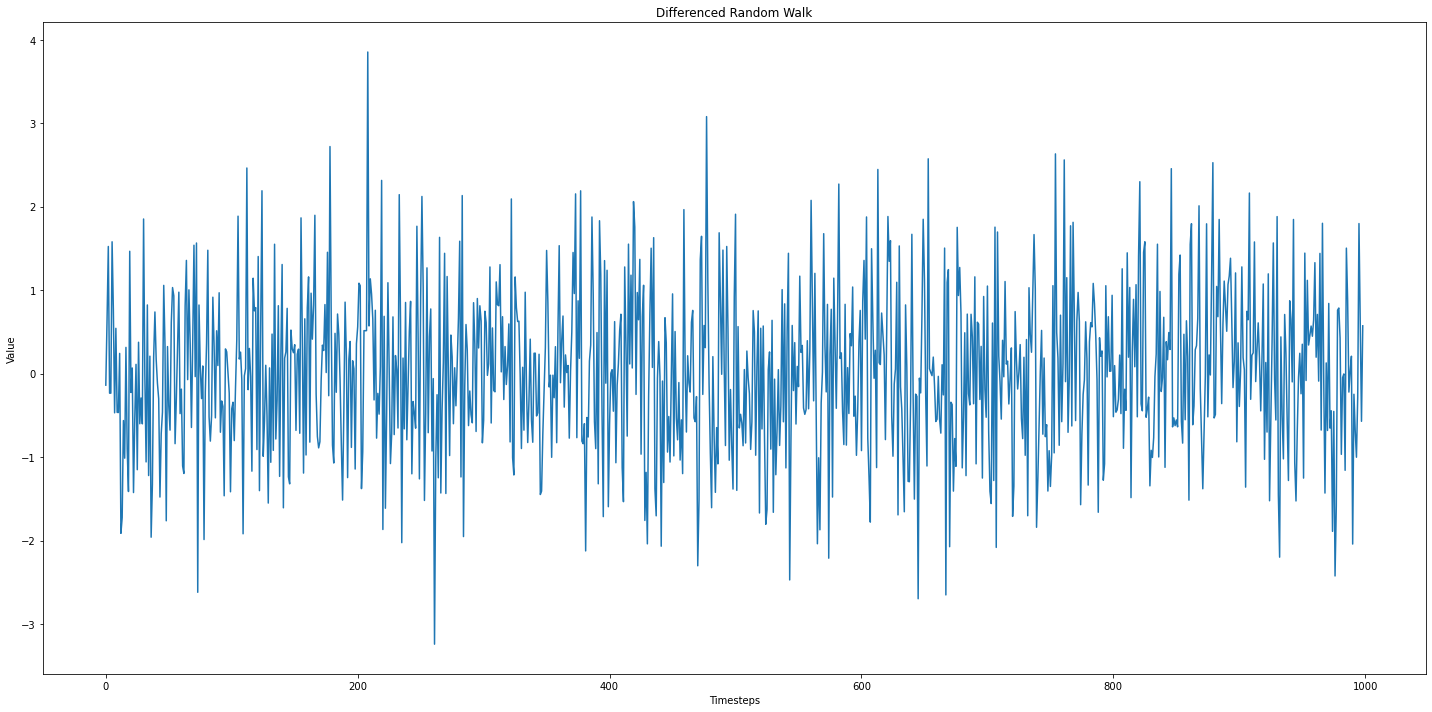

In [17]:
plt.figure(figsize = (20, 10))

plt.plot(diff_random_walk)

plt.title('Differenced Random Walk')

plt.xlabel('Timesteps')

plt.ylabel('Value')

plt.tight_layout()

In [18]:
ADF_result = adfuller(diff_random_walk)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -31.789310857560615
p-value: 0.0


This prints out an ADF statistic of –31.79 with a p-value of 0. This time the ADF statistic is a large negative number, and the p-value is less than 0.05. Therefore, we reject the null hypothesis, and we can say that this process has no unit root and is thus stationary.

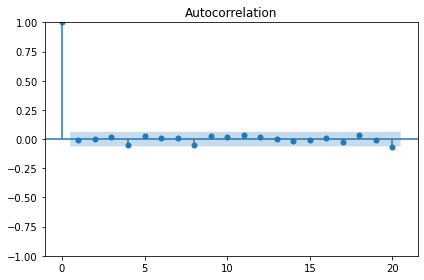

In [19]:
plot_acf(diff_random_walk, lags=20);

plt.tight_layout()

There are no significant autocorrelations after lag 0. This means that the stationary process is completely random and can therefore be described as white noise. Each value is simply a random step away from the previous one, with no relation between them. Let-s know check GOOG data

In [20]:
GOOGL_ADF_result = adfuller(data)

print(f'ADF Statistic: {GOOGL_ADF_result[0]}')
print(f'p-value: {GOOGL_ADF_result[1]}')

ADF Statistic: -0.5780248458627547
p-value: 0.8758706013155413


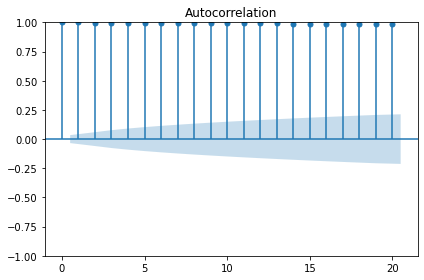

In [21]:
plot_acf(data, lags=20)

plt.tight_layout()

From the results differencing is required!

In [22]:
diff_close = np.diff(data, n=1)

In [23]:
GOOGL_ADF_result = adfuller(diff_close)

print(f'ADF Statistic: {GOOGL_ADF_result[0]}')
print(f'p-value: {GOOGL_ADF_result[1]}')

ADF Statistic: -13.186287343540757
p-value: 1.1683514931325548e-24


The series now is stationary. Looking at the acf plot:

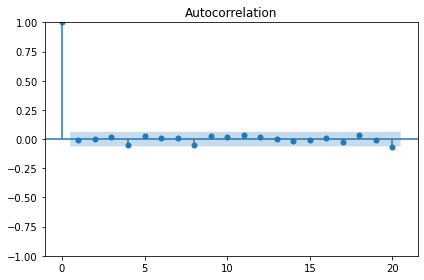

In [24]:
plot_acf(diff_random_walk, lags=20);

plt.tight_layout()

There are no significant autocorrelations after lag 0. This means that the stationary process is completely random and can therefore be described as white noise.

## **Making Predictions**

#### **Auto Regressive (p)**

An autoregressive process establishes that the output variable depends linearly on its own previous values. In other words, it is a regression of the variable against itself. An autoregressive process is denoted as an AR(p) process, where p is the order. In such a process, the present value yt is a linear combination of a constant C, the present error term εt, which is also white noise, and the past values of the series yt–p. The magnitude of the influence of the past values on the present value is denoted as φp, which represents the coefficients of the AR(p) model. It is given by:

yt = C + φ1y t –1 + φ2yt–2 +⋅⋅⋅ φpyt–p + εt 


Similar to the moving average process, the order p of an autoregressive process determines the number of past values that affect the present value. If we have a first-order autoregressive process, also denoted as AR(1), then the present value yt is only dependent on a constant C, the value at the previous timestep φ1yt –1, and some white noise εt.

Just like with the moving average process, there is a way to determine the order p of a stationary autoregressive process.

In [25]:
df = pd.read_csv(r'C:\Users\raimu\Desktop\New folder (2)\foot_traffic.csv')

df.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


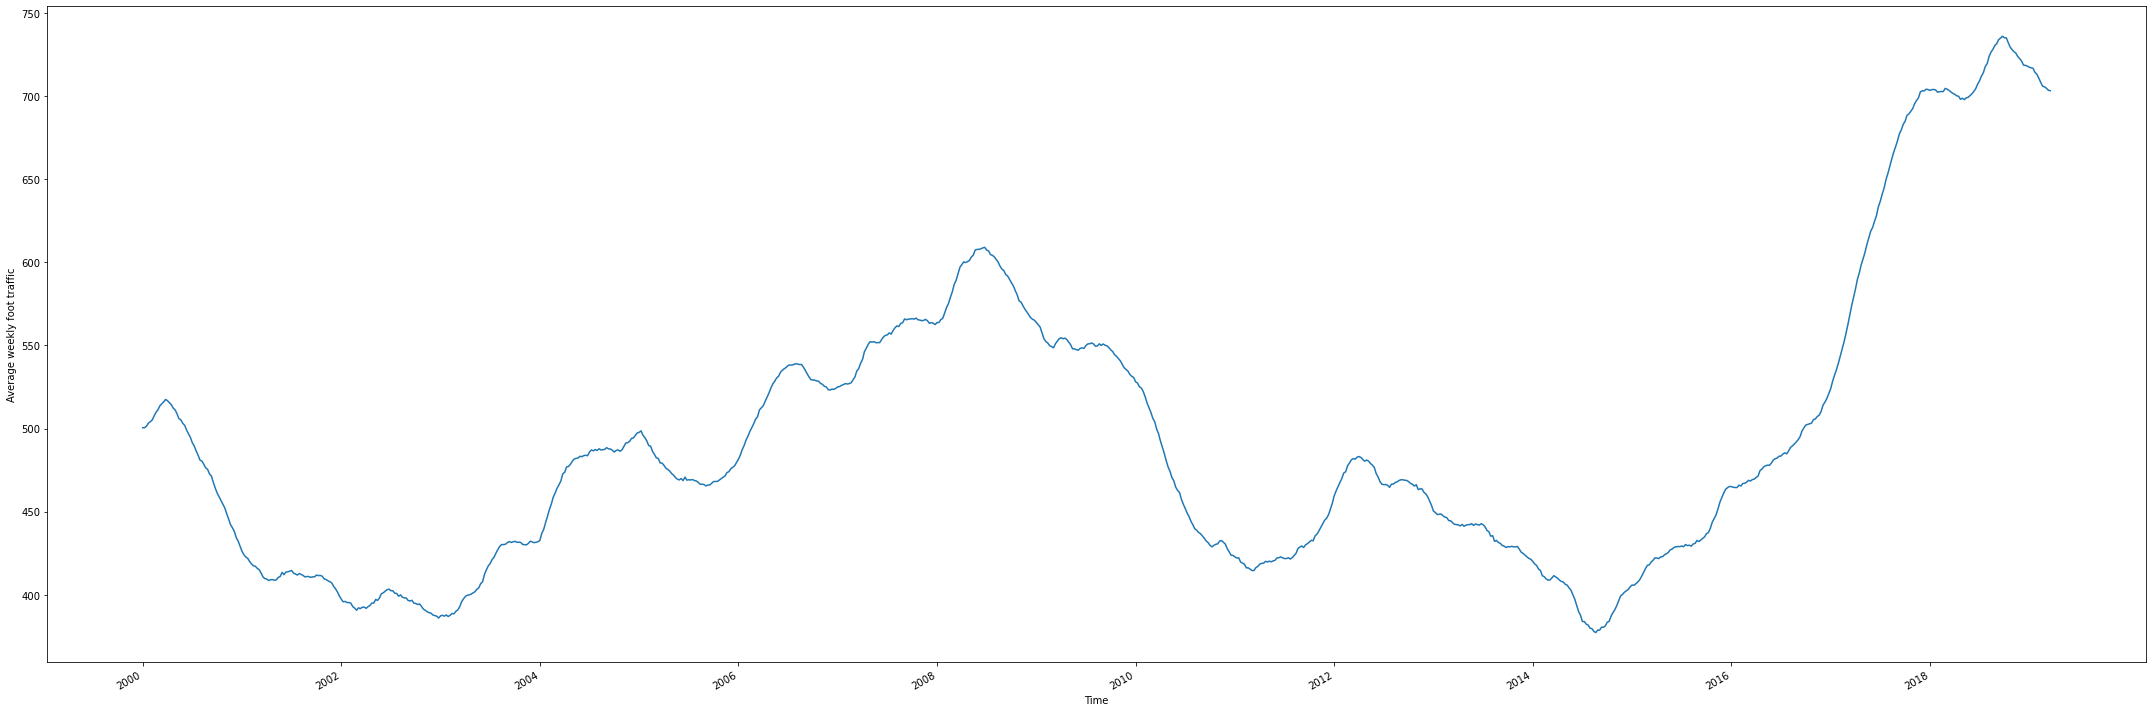

In [26]:
fig, ax = plt.subplots(figsize = (30, 10))

ax.plot(df['foot_traffic'])
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

The next step is to check for stationarity. As mentioned before, the presence of a trend means that our series is likely non-stationary. Let’s verify that using the ADF test.

In [27]:
ADF_result = adfuller(df['foot_traffic'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.175888599924077
p-value: 0.683880891789618


From the ADF the series is not stationary! So first order difference is applied

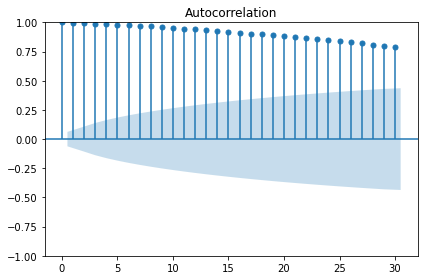

In [28]:
plot_acf(df['foot_traffic'], lags=30);

plt.tight_layout()

**Applying first order differencing**

In [29]:
foot_traffic_diff = np.diff(df['foot_traffic'], n=1)

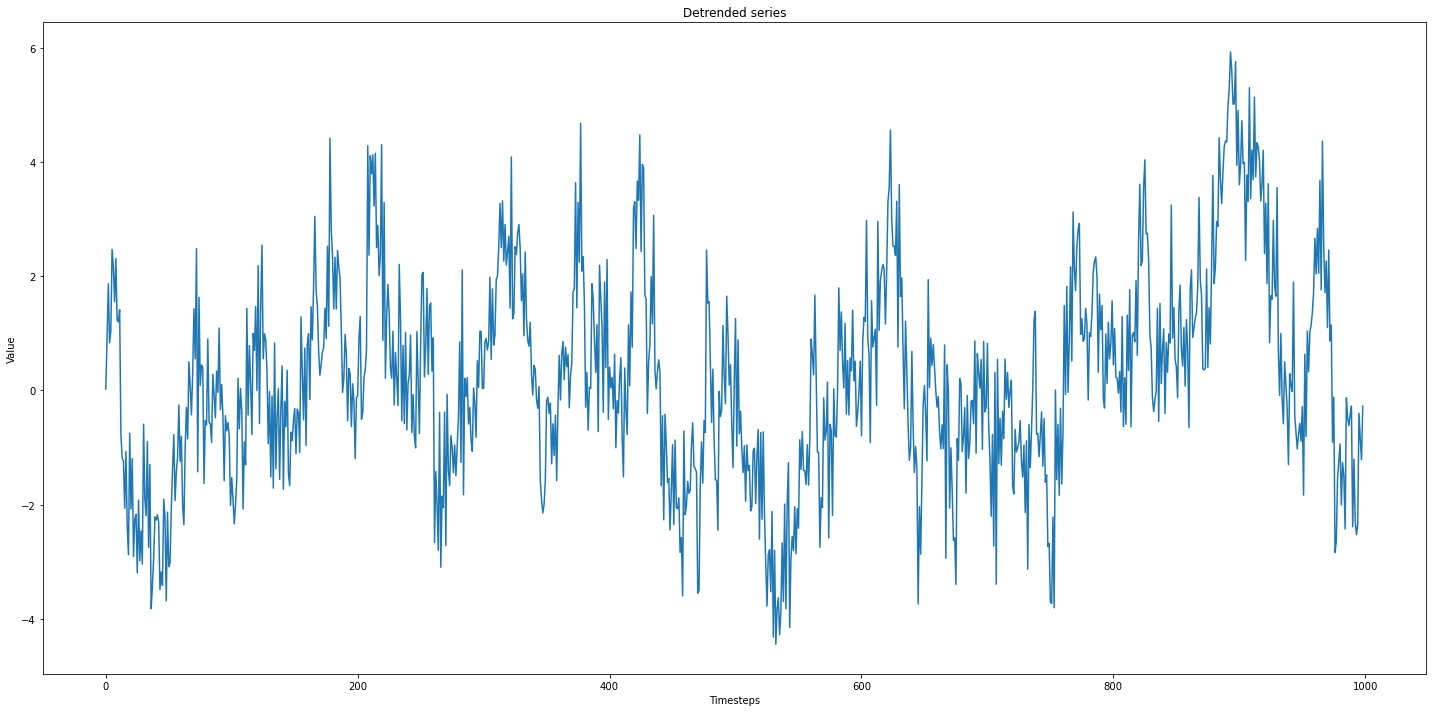

In [30]:
plt.figure(figsize = (20, 10))

plt.plot(foot_traffic_diff)

plt.title('Detrended series')

plt.xlabel('Timesteps')

plt.ylabel('Value')

plt.tight_layout()

In [31]:
ADF_result = adfuller(foot_traffic_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -5.268231347422041
p-value: 6.369317654781405e-06


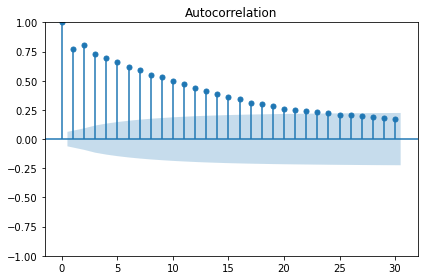

In [32]:
plot_acf(foot_traffic_diff, lags=30);

plt.tight_layout()

Looking at the Autocorrelation plot, you’ll notice that we have significant autocorrelation coefficients beyond lag 0. Therefore, we know that our process is not a random walk. Fur-thermore, you’ll notice that the coefficients are decaying exponentially as the lag increases.Therefore, there is no lag at which the coefficients abruptly become non-significant. This means that we do not have a moving average process and that we are likely studying an autoregressive process. When the ACF plot of a stationary process exhibits a pattern of exponential decay, we probably have an autoregressive process in play, and we must find another way to identify the order p of the AR(p) process. Specifically, we must turn our attention to the partial autocorrelation function (PACF) plot. Partial autocorrelation measures the correlation between lagged values in a time
series when we remove the influence of correlated lagged values in between. We can plot the partial autocorrelation function to determine the order of a stationary AR(p) process. The coefficients will be non-significant after lag p.

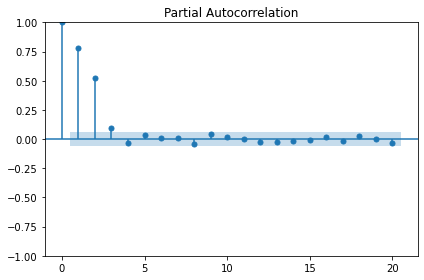

In [33]:
plot_pacf(foot_traffic_diff, lags=20);

plt.tight_layout()

You can see that there are no significant coefficients after lag 3.Therefore, the differenced average weekly foot traffic is an autoregressive process oforder 3, which can also be denoted as AR(3). Bellow we have the orginal time series and the detrended time series

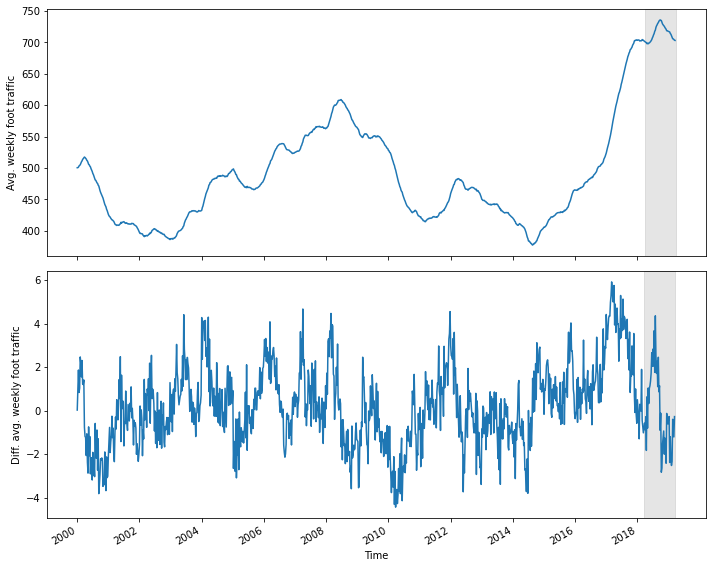

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(df['foot_traffic'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Avg. weekly foot traffic')
ax1.axvspan(948, 1000, color='#808080', alpha=0.2)

ax2.plot(foot_traffic_diff)
ax2.set_xlabel('Time')
ax2.set_ylabel('Diff. avg. weekly foot traffic')
ax2.axvspan(947, 999, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

In [35]:
df_diff = pd.DataFrame({'foot_traffic_dif': foot_traffic_diff})

train = df_diff[:int(0.9*len(foot_traffic_diff))]

test = df_diff[int(0.9*len(foot_traffic_diff)):]

In [36]:
print('Train Size:', len(train))
print('Test Size:', len(test))

Train Size: 899
Test Size: 100


Remember we have 999 records as one of them was removed when we differenciated!

Given that our objective is to forecast next week’s average foot traffic at the retail store, we will perform rolling forecasts over our test set. Remember that our data was recorded over a weekly period, so predicting the next timestep means we’re forecasting next week’s average foot traffic. We will forecast using three different methods. The historical mean method and the last known value method will act as baselines, and we will use an AR(3) model, since we previously established that we have a stationary third-order autoregressive process. As we did in the previous chapter, we will use the mean squared error (MSE) to evaluate the performance of each forecasting method.

In [37]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR

In [39]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1 ## We want to predict the next time step so we consider a window of just one

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head()

,foot_traffic_dif,pred_mean,pred_last_value,pred_AR
899,4.902001,0.103587,3.943732,4.529184
900,3.599489,0.108918,4.902001,4.041646
901,3.943638,0.112792,3.599489,3.899404
902,4.722737,0.117039,3.943638,3.479422
903,3.973385,0.122140,4.722737,3.769927


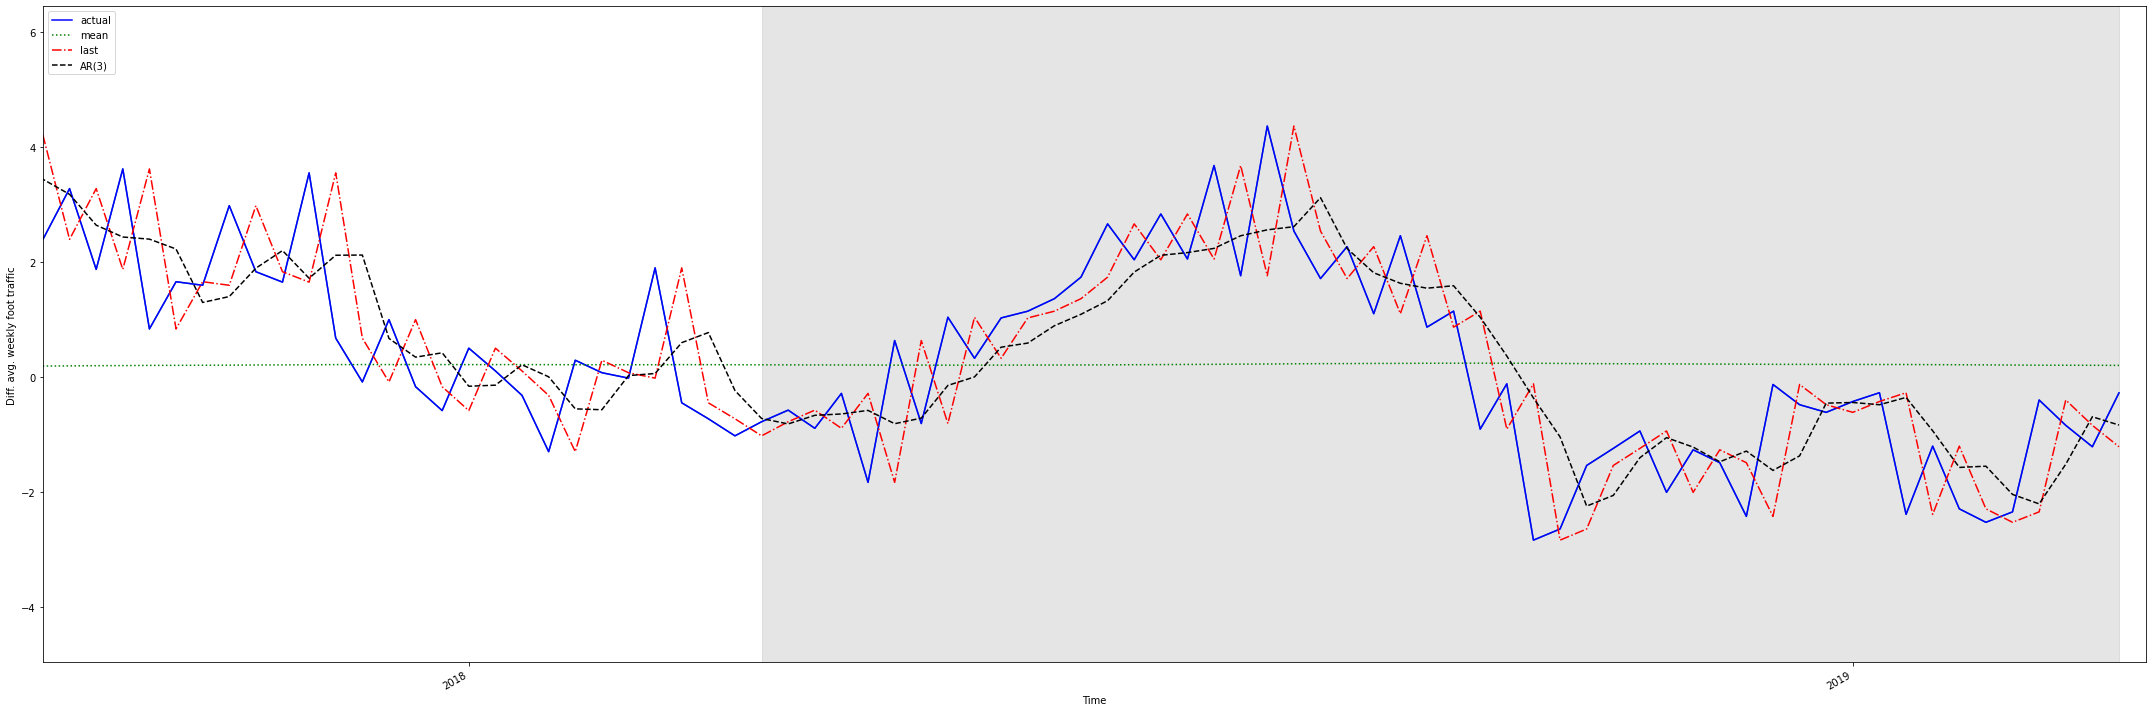

In [40]:
fig, ax = plt.subplots(figsize = (30,10))

ax.plot(df_diff['foot_traffic_dif'])
ax.plot(test['foot_traffic_dif'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_AR'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Diff. avg. weekly foot traffic')

ax.axvspan(947, 998, color='#808080', alpha=0.2)

ax.set_xlim(920, 999)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()


Looking at figure, you’ll see that, once again, using the historical mean producesa straight line, which is shown in the plot as a dotted line. As for the predictions fromthe AR(3) model and the last known value method, the curves are almost confounding with that of the test set, so we will have to measure the MSE to assess which method performs the best

In [41]:
mse_mean = mean_squared_error(test['foot_traffic_dif'], test['pred_mean'])
mse_last = mean_squared_error(test['foot_traffic_dif'], test['pred_last_value'])
mse_AR = mean_squared_error(test['foot_traffic_dif'], test['pred_AR'])

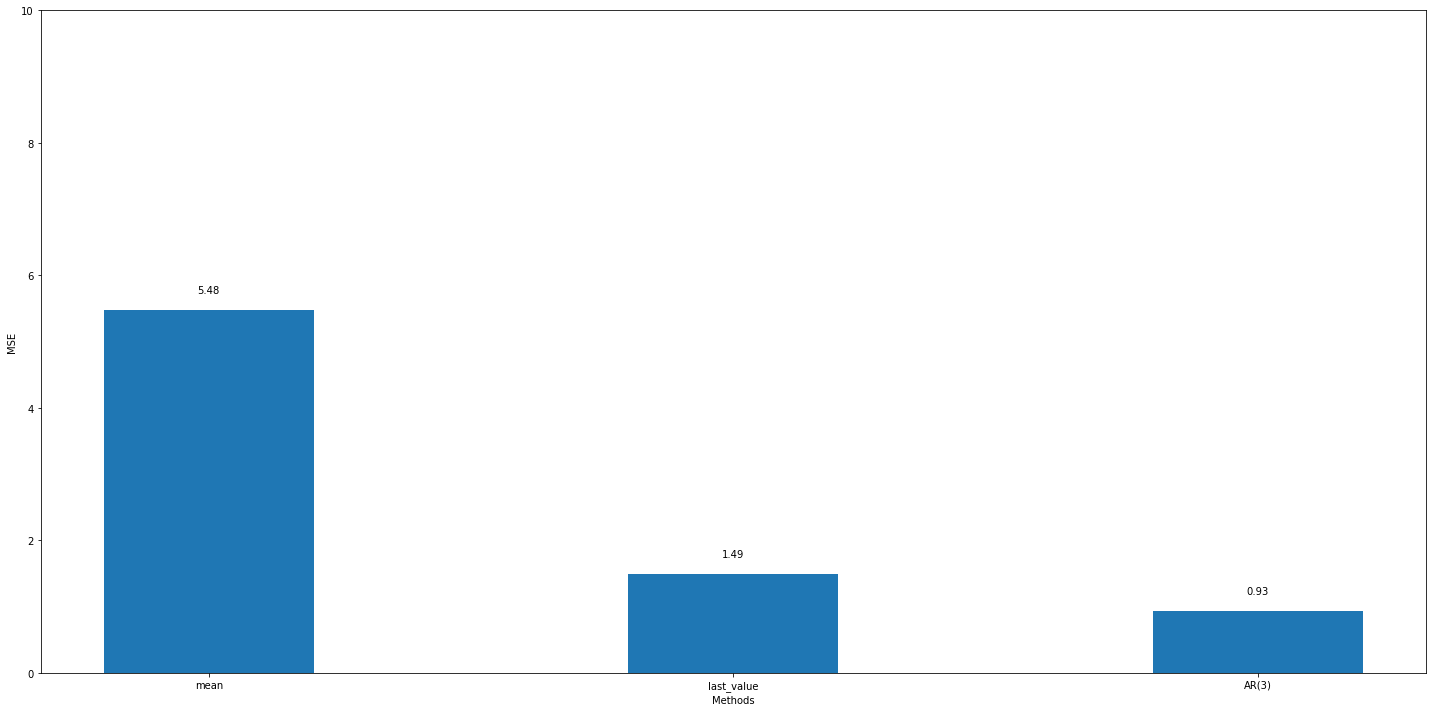

In [42]:
fig, ax = plt.subplots(figsize = (20,10))

x = ['mean', 'last_value', 'AR(3)']
y = [mse_mean, mse_last, mse_AR]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 10)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

This prints out an MSE of 5.48 for the historical mean method, 1.49 for the last known value method, and 0.93 for the AR(3) model. Since the MSE for the AR(3) model is the lowest of the three, we conclude that the AR(3) model is the best-performing method for forecasting next week’s average foot traffic. This is expected, since we established that our stationary process was a third-order autoregressive process. It makes sense that modeling using an AR(3) model will yield the best predictions.
Since our forecasts are differenced values, we need to reverse the transformation in order to bring our forecasts back to the original scale of the data; otherwise, our predictions will not make sense in a business context. To do this, we can take the cumulative sum of our predictions and add it to the last value of our training set in the original series.

In [49]:
df['pred_foot_traffic'] = pd.Series()

df['pred_foot_traffic'][900:] = df['foot_traffic'].iloc[900] + test['pred_AR'].cumsum()

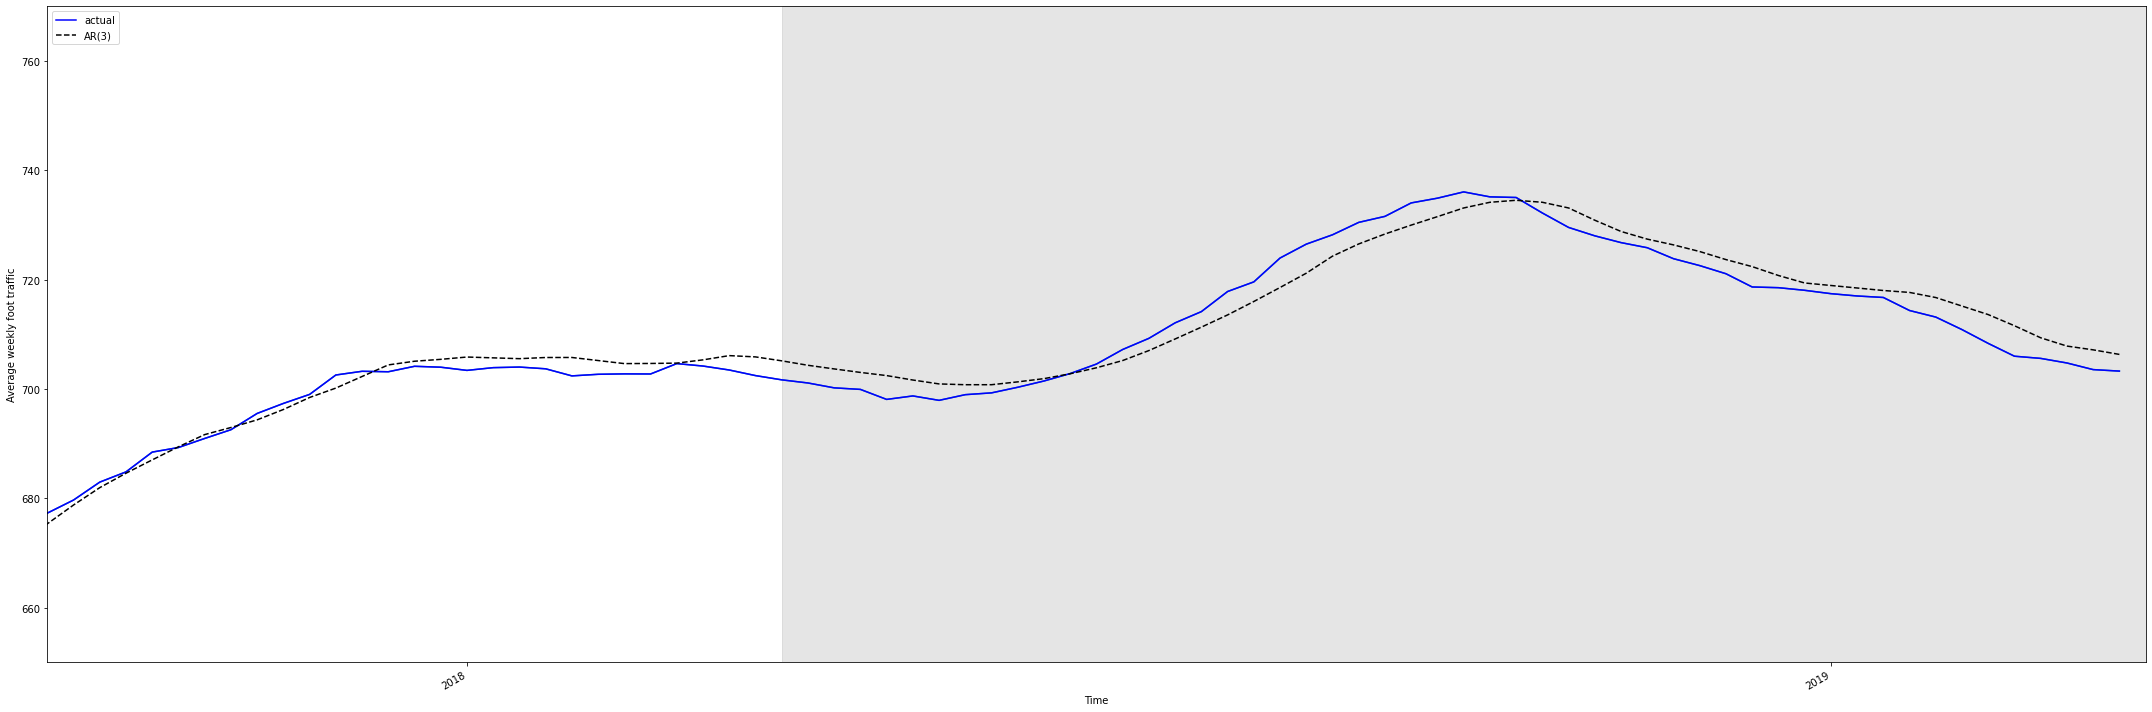

In [53]:
fig, ax = plt.subplots(figsize = (30,10))

ax.plot(df['foot_traffic'])
ax.plot(df['foot_traffic'], 'b-', label='actual')
ax.plot(df['pred_foot_traffic'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

ax.axvspan(948, 1000, color='#808080', alpha=0.2)

ax.set_xlim(920, 1000)
ax.set_ylim(650, 770)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()